# Survey of Models: Multi-layered Perceptron
In this workshop, we'll be learning about specific type of feed-forward neural networks, known as "Multi-layered Perceptrons."

Neural Networks generally look like the following:
network.svg
[Source](https://hyperskill.org/learn/step/26997).

Each "node" consists of a linear transformation on the output of all nodes in the previous layer, as well as an activation function on the output.

Multi-layered Perceptrons are the standard form of neural networks, and can be used for a variety of supervised learning tasks.

We can classify images, predict stock prices, play chess, and much more.

In [ ]:
%pip install torch
%pip install matplotlib
%pip install numpy

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import math
import random
import numpy as np
import matplotlib.pyplot as plt

First thing's first: let's "build" our actual neural network using Pytorch. We'll define the `Network` class which represents our neural network with it's specific configuration. Each object of this class will have the same structure, but different weights.

In [ ]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(in_features = 28*28, out_features = 120)
    self.fc2 = nn.Linear(in_features = 120, out_features = 60)
    self.out = nn.Linear(in_features = 60, out_features = 10)

  def forward(self, t):
    t = torch.flatten(t, start_dim=1)

    t = self.fc1(t)
    t = F.relu(t)

    t = self.fc2(t)
    t = F.relu(t)

    output = self.out(t)
    output = F.softmax(output, dim=1)

    return output


########## Or use nn.Sequential" ############
# class Network_alternative(nn.Module):
#   def __init__(self, in_size):
#     super().__init__()
#     self.layers = nn.Sequential(
#         nn.Linear(in_features = in_size, out_features = 120),
#         nn.ReLU(),
#         nn.Linear(in_features = 120, out_features = 60),
#         nn.ReLU(),
#         nn.Linear(in_features = 60, out_features = 10),
#         nn.Softmax(dim=1)
#     )

#   def forward(self, t):
#     t = torch.flatten(t, start_dim=1)
#     return self.layers(t)


We define the layers as attributes of this class, and define the forward pass as a method. As you see below, we can call this function just by referencing the object

In [ ]:
# Just some dummy data
network = Network()
print(network, '\n\n')

dummy_data = torch.rand(5,28,28)
output = network(dummy_data)

print(output.shape)
print(output)
print(output[0][0].item())

We'll load a dataset called the MNIST dataset. This is a standard dataset used often as a sanity check to see if your neural network is training properly.

These are images of numbers, and the neural network trains on the pixels of each image to predict the number it is depicting

In [ ]:
training_data = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
  )

test_data = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 466kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.73MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.19MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# NOTICE: 60 000 training samples, 10 000 test samples
print(f'len(training_data) = {len(training_data)}')
print(f'len(test_data) = {len(test_data)}\n')

# Each sample is a tuple of size 2 -- one tensor, one label
print(f'type / len of _data[0]: {len(training_data[0])}, {type(training_data[0])}')

# Tensor is the actual image -- 28 x 28
print(f'Tensor shape: {training_data[0][0].shape}')
print(f'Label: {training_data[0][1]}')

len(training_data) = 60000
len(test_data) = 10000

type / len of _data[0]: 2, <class 'tuple'>
Tensor shape: torch.Size([1, 28, 28])
Label: 5


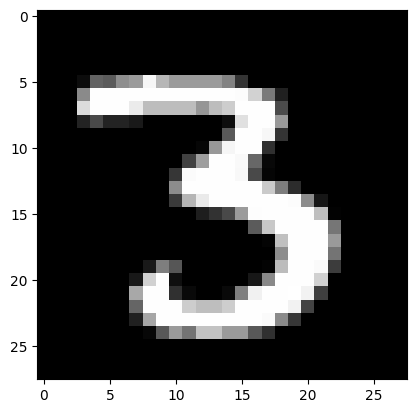

In [ ]:
plt.imshow(training_data[12][0].squeeze(), cmap='gray')
plt.show()

We'll use Pytorch's built in `Dataloader` class to abstract the dataset and iterate over it, pulling batches of a specified size and shuffling the data every epoch.

In [ ]:
from torch.utils.data import DataLoader

# DataLoader can wrap any "dataset" class that implements a len & get_item function
# Pytorch implements MNIST dataset as such a class, but we can build such a class
# with any dataset and wrap it with the DataLoader class.

train_dataloader = DataLoader(training_data, batch_size = 128, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size = 128, shuffle=True)

# Each time we "iterate" through the dataloader, we get a batch of examples and labels
batch = next(iter(train_dataloader))
print(f'Type of batch: {type(batch)} ; len of batch: {len(batch)}')
print(f'Batch[0]: {batch[0].shape} \nBatch[1]: {batch[1].shape}')

Type of batch: <class 'list'> ; len of batch: 2
Batch[0]: torch.Size([128, 1, 28, 28]) 
Batch[1]: torch.Size([128])


In [ ]:
network = Network()
LR = 0.01 # Rate at which we update weights
EPOCHS = 6 # Num passes thru dataset
opt = torch.optim.Adam(network.parameters(), lr=LR) # adam optimizer
loss_fn = nn.CrossEntropyLoss()
train_losses = []
test_losses = []

Let's define some functions to train our neural network. We want one function to make predictions, calculate loss, backpropagate through the network weights, and update them according to our optimizer function.

For our second function, we just want to monitor its performance on the test dataset -- data it hasn't seen before.

In [ ]:
def train_step(model, examples, labels, optimizer, loss_fn):
    optimizer.zero_grad()
    predictions = model(examples)
    loss = loss_fn(predictions, labels)
    loss.backward()
    opt.step()
    return loss.item()

def validate(model, examples, labels, loss_fn):
    predictions = model(examples)
    loss = loss_fn(predictions, labels)
    return loss.item()

Let's set up the main training loop! We'll instantiate our `Network` object, define some hyperparameters, and create the main training loop

In [ ]:
def train(network, EPOCHS, optimizer, train_dataloader, test_dataloader):

  for step in range(EPOCHS):
    for (examples, labels) in train_dataloader:
      train_loss = train_step(network, examples, labels, optimizer, loss_fn)
      train_losses.append(train_loss)

      test_loss = validate(network, examples, labels, loss_fn)
      test_losses.append(test_loss)


    # test_loss = 0
    # for (examples, labels) in test_dataloader:
    #   test_loss += validate(network, examples, labels, loss_fn)

    # test_loss /= len(test_dataloader)


    print(f'Epoch: {step}, Train Loss: {sum(train_losses[-100:]) / 100:.4f}, Test Loss: {sum(test_losses[-100:]) / 100:.4f}')

train(network, EPOCHS, opt, train_dataloader, test_dataloader)

Epoch: 0, Train Loss: 1.5999, Test Loss: 1.5871
Epoch: 1, Train Loss: 1.5407, Test Loss: 1.5332
Epoch: 2, Train Loss: 1.5418, Test Loss: 1.5366
Epoch: 3, Train Loss: 1.5243, Test Loss: 1.5214
Epoch: 4, Train Loss: 1.5333, Test Loss: 1.5294
Epoch: 5, Train Loss: 1.5246, Test Loss: 1.5223


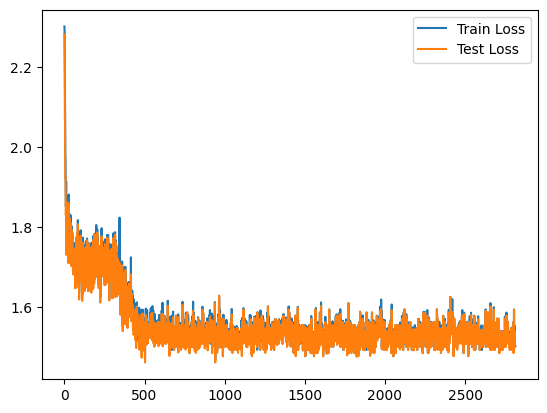

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

In [ ]:
test_data_full = DataLoader(test_data, batch_size=len(test_data))
examples, labels = next(iter(test_data_full))
predictions = network(examples).argmax(dim=1)
answers = list(map(bool, labels - predictions))
print((len(answers) - sum(answers)) / len(answers))

